# **Project 2**

## **Business Use Case**

### **Problem Statement:**

In the fast-paced environment of healthcare centers, healthcare professionals often face the challenge of quick and accurate diagnosis of patients while managing an ever-increasing volume of medical information. Ensuring that healthcare providers have access to the latest and most comprehensive medical knowledge is crucial for improving patient outcomes and reducing the time needed to make informed decisions.

There are multiple challenges that these professionals encounter daily, a few being

- Information Overload: Medical professionals need to go through vast amounts of data and research to make accurate diagnoses and treatment plans. This can be overwhelming and time-consuming.
- Efficiency: For overall patient care and quality health outcomes, quick and accurate diagnosis is vital, especially in emergency situations.
- Access to Trusted Knowledge: In the ever-evolving healthcare industry, providing access to reliable and up-to-date medical information from renowned manuals and research papers is essential for maintaining high standards of care.


### **Objective:**

A renowned chain of hospitals has decided to leverage AI to build a state-of-the-art solution to help healthcare professionals overcome the aforementioned challenges. They have recruited you as an AI specialist and tasked you with building a RAG-based AI solution that leverages renowned medical manuals as its knowledge base. This AI system will act as a POC towards an end product that’ll assist healthcare professionals in making better, quicker, and more accurate diagnoses, ultimately leading to faster patient resolutions and enabling better patient outcomes by reducing errors in diagnosis, saving valuable time for information retrieval, and standardizing care practices across the board.

### **Questions:**

**1. Diagnostic Assistance**: "What are the common symptoms and treatments for pulmonary embolism?"

**2. Drug Information**: "Can you provide the trade names of medications used for treating hypertension?"

**3. Treatment Plans**: "What are the first-line options and alternatives for managing rheumatoid arthritis?"

**4. Specialty Knowledge**: "What are the diagnostic steps for suspected endocrine disorders?"

**5. Critical Care Protocols**: "What is the protocol for managing sepsis in a critical care unit?"

### **How This Application Empowers Professionals and Elevates Healthcare Organizations**

- **Enhanced Diagnostic Accuracy:**
Provides evidence-based insights for better diagnosis and treatment.

- **Time Efficiency:**
Instantly retrieves critical information, saving valuable time.

- **Improved Patient Care:**
Ensures informed decisions with up-to-date medical knowledge.

- **Cost-Effective Operations:**
Reduces redundant tests and consultation delays, lowering costs.

- **Knowledge Empowerment:**
Keeps doctors updated on the latest advancements.

- **Competitive Edge for the Hospital:**
Positions the hospital as a leader in healthcare innovation.

This collaboration between St. Bernard’s Medical Center and InnoviTech Solutions highlights the transformative potential of AI in revolutionizing healthcare.

## **1. Install and Import Required Libraries**

In [1]:
# Install the Azure Machine Learning SDK and FAISS-related utilities
%pip install azure-ai-ml
%pip install -U 'azureml-rag[faiss,hugging_face]>=0.2.36'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 26.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: opentelemetry-api━━━━━━━━━━━━━━━━━━━━━━━━━  7/31 [strictyaml]
    Found existing installation: opentelemetry-api 1.35.0━━━━━  7/31 [strictyaml]
    Uninstalling opentelemetry-api-1.35.0:━━━━━━━━━━━━━━━━━━━━━━━━  8/31 [opentelemetry-api]
      Successfully uninstalled opentelemetry-api-1.35.0━━━━━━━━━━━  8/31 [opentelemetry-api]
  Attempting uninstall: opentelemetry-semantic-conventions━━━━  8/31 [opentelemetry-api]
    Found existing installation: opentelemetry-semantic-conventions 0.56b0/31 [opentelemetry-api]
    Uninstalling opentelemetry-semantic-conventions-0.56b0:━  9/31 [opentelemetry-semantic-conventions]
      Successfully uninstalled opentelemetry-semantic-conventions-0.56b0 [opentelemetry-semantic-conventions]
  Attempting uninstall: azure-storage-blob━━━━━━━━━━━━━━━━━━━━━━━━ 10/31 [azure-storage-file-share]ons]
    Found existing installation: azure-storage-blob 12.2

## **2. Configure Azure Machine Learning Workspace**

### Get client for AzureML Workspace

In [2]:
# Import necessary AzureML and authentication libraries
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azureml.core import Workspace

In [3]:
%%writefile workspace.json
{
    "subscription_id": "YOUR_SUBSCRIPTION_ID",
    "resource_group": "YOUR_RESOURCE_GROUP", 
    "workspace_name": "Medical_Assistant_Project"  
}

Overwriting workspace.json


In [4]:
# Initialize credentials for Azure authentication
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [5]:
# Initialize the MLClient to connect with AzureML
ml_client = MLClient.from_config(credential=credential, path="workspace.json")

Found the config file in: workspace.json


In [6]:
# Create an AzureML Workspace object
ws = Workspace(
    subscription_id=ml_client.subscription_id,
    resource_group=ml_client.resource_group_name,
    workspace_name=ml_client.workspace_name,
)


# Verify the client and workspace details
print(ml_client)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x71cdc2929270>,
         subscription_id=4f09e3ea-f8bf-4641-9b58-32f1b34d014c,
         resource_group_name=GL_May2025_Daniel,
         workspace_name=Medical_Assistant_Project)


## **3. Register the Reports Dataset as a Data Asset**

In [7]:
# Import libraries for data registration
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import zipfile
import os

# Path to the ZIP file containing Tesla annual reports
zip_file_path = 'MedicalDiagnosisManuals.zip'

# Directory to extract the reports
extract_to_directory = './extracted_dataset_reports'
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the ZIP file containing the reports
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

# Register the extracted data as a Data asset in AzureML
local_data_path = extract_to_directory
data_asset = Data(
    path=local_data_path,
    type=AssetTypes.URI_FOLDER,  # Registering as a folder URI
    description="MedicalDiagnosis collected manuals for embedding generation",
    name="MedicalDiagnosis-dataset-reports"
)

# Use the MLClient to register the data asset
ml_client.data.create_or_update(data_asset)
print(f"Data asset '{data_asset.name}' registered successfully.")

Data asset 'MedicalDiagnosis-dataset-reports' registered successfully.


## **4. Set Up Azure OpenAI Connection**

### Run the cells under _either_ heading (OpenAI or HuggingFace) to use the respective embedding model

#### **Note:**

When selecting an embedding model, ensure consistency between the embedding model used here and the one configured for your vectorstore retriever. Using mismatched models may result in dimension mismatches, leading to errors during vector retrieval. For example:

- If you use the `text-embedding-ada-002` model from Azure OpenAI for embedding creation, ensure the same model is specified for the vectorstore retriever.
- Similarly, if using a HuggingFace model like `all-mpnet-base-v2`, configure the vectorstore retriever with this model.

Maintaining alignment between the embedding model and vectorstore retriever is crucial for the proper functioning of your pipeline.

#### OpenAI

In [8]:
# # Azure Open AI redentials and the id of the deployed chat model are stored as
# # key value pairs in a json file

with open('config.json', 'r') as az_creds:
    data = az_creds.read()

# Credentials to authenticate to the personalized Open AI model server
import json
creds = json.loads(data)


In [9]:
from azureml.rag.utils.connections import get_connection_by_name_v2, create_connection_v2

# Define the connection name for Azure OpenAI
aoai_connection_name = "MedicalAssistant_AzureOpenAI_Connection"

# If the connection doesn't exist, create a new one
target = creds["AZURE_OPENAI_ENDPOINT"]  # Replace with your Azure OpenAI endpoint
key = creds["AZURE_OPENAI_KEY"]          # Replace with your Azure OpenAI API key
api_version = creds["AZURE_OPENAI_APIVERSION"]    # Replace with the appropriate API version

aoai_connection = create_connection_v2(
     workspace=ws,
     name=aoai_connection_name,
     category="AzureOpenAI",
     target=target,
     auth_type="ApiKey",
     credentials={"key": key},
     metadata={"ApiType": "azure", "ApiVersion": api_version},
 )

aoai_connection_id = aoai_connection["id"]

print(f"Azure OpenAI connection created or retrieved successfully: {aoai_connection_id}")

Azure OpenAI connection created or retrieved successfully: /subscriptions/4f09e3ea-f8bf-4641-9b58-32f1b34d014c/resourceGroups/GL_May2025_Daniel/providers/Microsoft.MachineLearningServices/workspaces/Medical_Assistant_Project/connections/MedicalAssistant_AzureOpenAI_Connection


To use the Azure OpenAI `text-embedding-ada-002` model for embedding generation, ensure the model has been deployed and is ready for inference. [Follow these instructions](https://learn.microsoft.com/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#deploy-a-model) to deploy the embedding model in your Azure OpenAI resource.

Once deployed, obtain the credentials for the text-embedding-ada-002 model and save them in your `config.json` file. This is necessary for the following code to execute successfully.

Ensure that the `config.json` file includes the appropriate keys:

- `AZURE_OPENAI_EMBEDDING_MODEL`: Name of the Azure OpenAI embedding model.
- `AZURE_OPENAI_EMBEDING_DEPLOYMENT`: Deployment name for the embedding model.

Finally we will combine the deployment and model information into a uri form which the AzureML embeddings components expect as input.

In [10]:
aoai_embedding_model_name = creds["AZURE_OPENAI_EMBEDDING_MODEL"]
aoai_embedding_deployment_name = creds["AZURE_OPENAI_EMBEDING_DEPLOYMENT"]
embeddings_model_uri = f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_embedding_model_name}"
print(f"Embedding Model URI: {embeddings_model_uri}")

Embedding Model URI: azure_open_ai://deployment/text-embedding-ada-002/model/text-embedding-ada-002


#### HuggingFace


In [11]:
# embeddings_model_uri = "hugging_face://model/sentence-transformers/_________"   #Fill the blank with embedding model

## **5. Setup Pipeline to process data into Index**

### **Define Pipeline Components**

In [12]:
# Import the MLClient to access the AzureML registry
ml_registry = MLClient(credential=credential, registry_name="azureml")

# Retrieve components for processing data, generating embeddings, and creating the FAISS index
crack_and_chunk_component = ml_registry.components.get(
    "llm_rag_crack_and_chunk", label="latest"
)
generate_embeddings_component = ml_registry.components.get(
    "llm_rag_generate_embeddings", label="latest"
)
create_faiss_index_component = ml_registry.components.get(
    "llm_rag_create_faiss_index", label="latest"
)
register_mlindex_component = ml_registry.components.get(
    "llm_rag_register_mlindex_asset", label="latest"
)


Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


In [13]:
print(crack_and_chunk_component)

$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: llm_rag_crack_and_chunk
version: 0.0.85
display_name: LLM - Crack and Chunk Data
description: 'Creates chunks no larger than `chunk_size` from `input_data`, extracted
  document titles are prepended to each chunk


  LLM models have token limits for the prompts passed to them, this is a limiting
  factor at embedding time and even more limiting at prompt completion time as only
  so much context can be passed along with instructions to the LLM and user queries.

  Chunking allows splitting source data of various formats into small but coherent
  snippets of information which can be ''packed'' into LLM prompts when asking for
  answers to user query related to the source documents.


  Supported formats: md, txt, html/htm, pdf, ppt(x), doc(x), xls(x), py

  '
tags:
  Preview: ''
type: command
inputs:
  input_data:
    type: uri_folder
    description: Uri Folder containing files to be chunked.
    op

### **Build the AzureML Pipeline**

In [14]:
from azure.ai.ml import Input, Output
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities._job.pipeline._io import PipelineInput
from typing import Optional


# Utility function for automatic compute configuration
def use_automatic_compute(component, instance_count=1, instance_type="Standard_NC4as_T4_v3"):
    """Configure a component to use automatic compute."""
    component.set_resources(
        instance_count=instance_count,
        instance_type=instance_type,
        properties={"compute_specification": {"automatic": True}},
    )
    return component


# Utility function to check if optional pipeline inputs are provided
def optional_pipeline_input_provided(input: Optional[PipelineInput]):
    """Check if optional pipeline inputs are provided."""
    return input is not None and input._data is not None


@pipeline(default_compute="serverless")
def MedicalDiagnosis_to_faiss(
    data_asset_path: str,
    embeddings_model: str,
    asset_name: str,
    chunk_size: int = 1024,
    data_source_glob: str = None,
    document_path_replacement_regex: str = None,
    aoai_connection_id=None,
    embeddings_container=None,
):
    """Pipeline to process finsights reports and create a FAISS vector index."""
    
    # Step 1: Chunk data into smaller pieces
    crack_and_chunk = crack_and_chunk_component(
        input_data=Input(type="uri_folder", path=data_asset_path),  # Input data asset
        input_glob=data_source_glob,
        chunk_size=chunk_size,
        document_path_replacement_regex=document_path_replacement_regex,
    )
    use_automatic_compute(crack_and_chunk)  # Apply compute configuration

    # Step 2: Generate embeddings for the data chunks
    generate_embeddings = generate_embeddings_component(
        chunks_source=crack_and_chunk.outputs.output_chunks,
        embeddings_container=embeddings_container,
        embeddings_model=embeddings_model,
    )
    use_automatic_compute(generate_embeddings)  # Apply compute configuration
    
    # Optional: Include Azure OpenAI connection ID
    if optional_pipeline_input_provided(aoai_connection_id):
        generate_embeddings.environment_variables[
            "AZUREML_WORKSPACE_CONNECTION_ID_AOAI"
        ] = aoai_connection_id
    
    if optional_pipeline_input_provided(embeddings_container):
        generate_embeddings.outputs.embeddings = Output(
            type="uri_folder", path=f"{embeddings_container.path}/{{name}}"
        )

    # Step 3: Create a FAISS vector index from embeddings
    create_faiss_index = create_faiss_index_component(
        embeddings=generate_embeddings.outputs.embeddings,
    )
    use_automatic_compute(create_faiss_index)  # Apply compute configuration

    # Step 4: Register the FAISS index as an MLIndex asset
    register_mlindex = register_mlindex_component(
        storage_uri=create_faiss_index.outputs.index, 
        asset_name=asset_name
    )
    use_automatic_compute(register_mlindex) # Apply compute configuration
    
    return {
        "mlindex_asset_uri": create_faiss_index.outputs.index,
        "mlindex_asset_id": register_mlindex.outputs.asset_id,
    }

## **6.Submit the Pipeline**

In [15]:
# Define the asset name and data source glob pattern
# asset_name = "finsights_faiss_index"  #Name for the FAISS index asset created using Huggingface model embeddings.
asset_name = "MedicalDiagnosis_faiss"  #Name for the FAISS index asset created using OpenAI model embeddings.
data_source_glob = "**/*.pdf"  # Pattern to match input data files

In [16]:
# Get the input data asset path from the workspace datastore
datastore_path = ml_client.data.get("MedicalDiagnosis-dataset-reports", version="1").path
print(f"Datastore path: {datastore_path}")


Datastore path: azureml://subscriptions/4f09e3ea-f8bf-4641-9b58-32f1b34d014c/resourcegroups/GL_May2025_Daniel/workspaces/Medical_Assistant_Project/datastores/workspaceblobstore/paths/LocalUpload/cef17248c7f29f30ea2c214f7b8ec95517c409fd45c7ebcc691f82985e647f0e/extracted_dataset_reports/


In [17]:
# Create the pipeline job by calling the defined pipeline function
pipeline_job = MedicalDiagnosis_to_faiss(
    embeddings_model=embeddings_model_uri,  # URI of the embeddings model
    aoai_connection_id=aoai_connection_id,  # Connection ID for Azure OpenAI (optional)
    embeddings_container=Input(
        type="uri_folder",
        path=f"azureml://datastores/workspaceblobstore/paths/embeddings/{asset_name}"
    ),  # Path for storing generated embeddings
    data_asset_path=Input(
        type="uri_folder",
        path=datastore_path
    ),  # Input data asset path
    chunk_size=1024,  # Size of chunks for processing
    data_source_glob=data_source_glob,  # Glob pattern for input files
    asset_name=asset_name,  # Name of the MLIndex asset
)

In [18]:
# Add properties for better indexing and artifact tracking in the AzureML UI
pipeline_job.properties["azureml.mlIndexAssetName"] = asset_name
pipeline_job.properties["azureml.mlIndexAssetKind"] = "faiss"
pipeline_job.properties["azureml.mlIndexAssetSource"] = "Data asset"

In [19]:
# Submit the pipeline job for execution
submitted_pipeline = ml_client.jobs.create_or_update(pipeline_job)
print(f"Pipeline submitted successfully! Job ID: {submitted_pipeline.id}")

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
pathOnCompute is not a known attribute

Pipeline submitted successfully! Job ID: /subscriptions/4f09e3ea-f8bf-4641-9b58-32f1b34d014c/resourceGroups/GL_May2025_Daniel/providers/Microsoft.MachineLearningServices/workspaces/Medical_Assistant_Project/jobs/sincere_hominy_241n8v5ch6


In [20]:
# Stream the pipeline job logs for real-time monitoring
ml_client.jobs.stream(submitted_pipeline.name)

RunId: sincere_hominy_241n8v5ch6
Web View: https://ml.azure.com/runs/sincere_hominy_241n8v5ch6?wsid=/subscriptions/4f09e3ea-f8bf-4641-9b58-32f1b34d014c/resourcegroups/GL_May2025_Daniel/workspaces/Medical_Assistant_Project

Execution Summary
RunId: sincere_hominy_241n8v5ch6
Web View: https://ml.azure.com/runs/sincere_hominy_241n8v5ch6?wsid=/subscriptions/4f09e3ea-f8bf-4641-9b58-32f1b34d014c/resourcegroups/GL_May2025_Daniel/workspaces/Medical_Assistant_Project



# **Information Retrieval and Response Generation Using LangChain-FAISS and Azure OpenAI**

## **1.Installing Required Libraries**

In [21]:
# Install the required LangChain and HuggingFace libraries
%pip install -U langchain-community
%pip install -U langchain-huggingface
%pip install -U langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 6.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.4/584.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: async-timeout90m━━━━━━━━━━━━━━━━━━━━━━━━━━  6/18 [greenlet]]
    Found existing installation: async-timeout 5.0.1━━━━━━━━━━  6/18 [greenlet]
    Uninstalling async-timeout-5.0.1:━━━━━━━━━━━━━━━━━━━━━━━━━  6/18 [greenlet]
      Successfully uninstalled async-timeout-5.0.1━━━━━━━━━━━━  6/18 [greenlet]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18/18 [langchain-community]ngchain-community]ters]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **2. Setting Up Data Retrieval**

### **Downloading and Setting Up FAISS Index Assets**


In [22]:
# Import necessary utilities for artifact retrieval
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

# Retrieve the path to the latest FAISS index asset from Azure ML
data_info = ml_client.data.get(name=asset_name, label="latest").path

# Download the FAISS index asset to a local directory
artifact_utils.download_artifact_from_aml_uri(
    uri=data_info,
    destination="./MedicalDiagnosisfaissindexasset/",
    datastore_operation=ml_client.datastores
)


'./MedicalDiagnosisfaissindexasset/'

## **3. Loading the FAISS Index**

### **Loading the FAISS Index and Preparing the Retriever**

We load the FAISS index from the downloaded files and connect it to an embedding model. This embedding model ensures that queries are converted into vector space to match the stored documents effectively.

### **Note:**
When loading the FAISS index and setting up the retriever, it is crucial to use the same embedding model that was used during the creation of the FAISS index. This ensures that the dimensionality of the embeddings produced by the query matches the dimensionality of the embeddings stored in the FAISS index.

If a different embedding model is used between these two steps, a dimension mismatch will occur, leading to errors in retrieving relevant documents or performing similarity searches.

In [23]:
# Path to the directory containing FAISS index files
index_folder_path = "./MedicalDiagnosisfaissindexasset/"

In [24]:
from langchain_huggingface import HuggingFaceEmbeddings

# Specify the embedding model used during FAISS index creation
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:01<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [25]:
from langchain_openai import AzureOpenAIEmbeddings

# # Specify the embedding model used during FAISS index creation
embedding_model = AzureOpenAIEmbeddings(
    model=creds["AZURE_OPENAI_EMBEDDING_MODEL"],
    azure_endpoint= creds["AZURE_OPENAI_ENDPOINT"],
    api_key= creds["AZURE_OPENAI_KEY"],
    openai_api_version=creds["AZURE_OPENAI_APIVERSION"]
 )

In [26]:
from langchain.vectorstores import FAISS

# Load the FAISS index and associate it with the embedding model
retriever = FAISS.load_local(
    folder_path=index_folder_path, 
    embeddings=embedding_model, 
    allow_dangerous_deserialization=True  # Acknowledge the source of the data for safe loading
)


# The retriever is now ready to perform similarity searches.

## **4. Performing a Similarity Search**

In [27]:
# Define a query to test the retriever
query = "What are the common symptoms and treatments for pulmonary embolism?"

# Retrieve the top 3 most relevant documents
results = retriever.similarity_search(query, k=3)

# Display the results
for doc in results:
    print(f"Document: {doc.page_content}\nMetadata: {doc.metadata}")

# This step helps validate that the retriever is functioning as expected.

Document: Title: The_Merck_Manual_of_Diagnosis_and_Therapy_2011 - 19th Edn........pdfChapter 194. Pulmonary Embolism
Introduction
Pulmonary embolism (PE) is the occlusion of ≥ 1 pulmonary arteries by thrombi that originate
elsewhere, typically in the large veins of the lower extremities or pelvis. Risk factors are
conditions that impair venous return, conditions that cause endothelial injury or dysfunction,
and underlying hypercoagulable states. Symptoms are nonspecific and include dyspnea,
pleuritic chest pain, cough, and, in severe cases, syncope or cardiorespiratory arrest. Signs are
also nonspecific and may include tachypnea, tachycardia, hypotension, and a loud pulmonic
component of the 2nd heart sound. Diagnosis is based on a CT angiogram, ventilation/perfusion
scan, or a pulmonary arteriogram. Treatment is with anticoagulants and, sometimes, clot
dissolution with thrombolytics or surgical removal. Preventive measures include anticoagulants
and sometimes insertion of an inferior 

## **5: Creating the System and User Prompt Templates**

In [28]:
# Define the system prompt for the Azure OpenAI model
qna_system_message = """
You are an assistant to a Healthcare Professional. Your task is to summarize and provide clinically relevant information to the clinician's question based strictly on the provided context drawn from trusted medical manuals and peer-reviewed sources.

User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with page number from the source.
The source for the context will begin with the token ###Page

When crafting your response:
1. Select only context relevant to answer the question.
2. Include the source links and page numbers in your response.
3. User questions will begin with the token: ###Question.
4. If the question is irrelevant or if the context is empty — respond with "Sorry, this is out of my knowledge base"

Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- Do not fabricate or infer information not present in the context.
- If multiple context snippets disagree, present the differing viewpoints succinctly and include sources.
- If the answer is not found in the context, it is very very important for you to respond with "Sorry, this is out of my knowledge base"
- If NO CONTEXT is provided, it is very important for you to respond with "Sorry, this is out of my knowledge base"
- Keep answers concise and clinically actionable. When relevant and present in the context, prioritize: diagnostic criteria, red flags, initial workup, first-line treatments, dosing (adult/pediatric as applicable), contraindications, major adverse effects, and key differentials.
- This tool supports clinical decision-making but does not replace professional judgment.

Here is an example of how to structure your response:

Answer:
[Answer]

Page:
[Page number]
"""


# Define the user message template
qna_user_message_template = """
###Context
Here are some documents and their page number that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

## **6. Generating the Response**

In [29]:
# Install the rquired packages
#!pip install openai==1.55.3 tiktoken==0.6 session-info --quiet

In [30]:
# Import required libraries
import json
import tiktoken
import pandas as pd
from openai import AzureOpenAI

In [31]:
# Load Azure OpenAI credentials
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

creds = json.loads(data)

In [32]:
# Initialize the Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)   

In [33]:
##Create a function called generate_rag_response which can perform

def generate_rag_response(user_input):
    try:
        # Retrieve relevant document chunks
        relevant_document_chunks = retriever.similarity_search(user_input, k=3)
        context_list = [d.page_content for d in relevant_document_chunks]

        # Combine document chunks into a single context
        context_for_query = ". ".join(context_list)

        # Compose the prompt
        prompt = [
            {'role': 'system', 'content': qna_system_message},
            {'role': 'user', 'content': qna_user_message_template.format(
                context=context_for_query,
                question=user_input
            )}
        ]

        # Generate the response using Azure OpenAI
        completion = client.chat.completions.create(
            model=creds["CHATGPT_MODEL"],
            messages=prompt,
            temperature=0
        )

        # Extract and return the model's response
        return completion.choices[0].message.content.strip()

    except Exception as e:
        return f"Sorry, I encountered the following error: \n {e}"

#### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [34]:
user_input = "What is the protocol for managing sepsis in a critical care unit?"    # Enter the question to be answered by the system here 
generate_rag_response(user_input)

'Answer:\nThe protocol for managing sepsis in a critical care unit includes:\n\n1. **Fluid Resuscitation**: Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg or pulmonary artery occlusive pressure (PAOP) reaches 12-15 mm Hg. Oliguria with hypotension is not a contraindication to vigorous fluid resuscitation, and the total fluid volume may exceed 10 L over 4 to 12 hours.\n\n2. **Oxygen Therapy**: Provide supplemental oxygen via mask or nasal prongs; mechanical ventilation may be necessary for respiratory failure.\n\n3. **Broad-Spectrum Antibiotics**: Initiate empiric antibiotic therapy promptly after obtaining cultures. Adjust based on culture results. Common regimens include:\n   - Gentamicin or tobramycin plus a 3rd-generation cephalosporin (e.g., cefotaxime or ceftriaxone).\n   - Add vancomycin if resistant staphylococci or enterococci are suspected.\n   - Include metronidazole if an abdominal source is suspected.\n\n4. **Monitoring**: Frequently monit

#### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [35]:
user_input = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"   # Enter the question to be answered by the system here 
generate_rag_response(user_input)

"Common symptoms of appendicitis include:\n- Epigastric or periumbilical pain that shifts to the right lower quadrant\n- Brief nausea, vomiting, and anorexia\n- Pain that increases with cough and motion\n- Right lower quadrant direct and rebound tenderness at McBurney's point\n- Additional signs such as Rovsing sign, psoas sign, and obturator sign\n- Low-grade fever (rectal temperature 37.7 to 38.3° C [100 to 101° F])\n\nAppendicitis cannot be cured with medicine alone; surgical removal of the appendix (appendectomy) is required. This can be performed either through an open or laparoscopic approach. Preceding the surgery, intravenous (IV) antibiotics should be administered.\n\nPage:\n164-165"

#### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [36]:
user_input = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"   # Enter the question to be answered by the system here 
generate_rag_response(user_input)

'Alopecia areata, characterized by sudden patchy hair loss, can be treated with several options. Effective treatments include:\n\n1. **Topical Corticosteroids**: These are commonly used to reduce inflammation and promote hair regrowth.\n2. **Intralesional Corticosteroids**: Injecting corticosteroids directly into the bald patches can be effective.\n3. **Systemic Corticosteroids**: In severe cases, oral corticosteroids may be considered.\n4. **Topical Minoxidil**: This can be used to stimulate hair growth.\n5. **Topical Anthralin**: A topical treatment that can help in some cases.\n6. **Topical Immunotherapy**: Agents like diphencyprone or squaric acid dibutylester can be used to provoke an immune response that may help regrow hair.\n7. **Psoralen plus Ultraviolet A (PUVA)**: This treatment combines a medication with light therapy.\n\nPossible causes of alopecia areata include autoimmune disorders, where the immune system mistakenly attacks hair follicles, and genetic susceptibility, of

#### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [37]:
user_input = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"   # Enter the question to be answered by the system here 
generate_rag_response(user_input)

'Initial treatment for traumatic brain injury (TBI) includes ensuring a reliable airway and maintaining adequate ventilation, oxygenation, and blood pressure. In cases of more severe injury, surgical intervention may be necessary to monitor and treat intracranial pressure, decompress the brain if intracranial pressure is increased, or remove intracranial hematomas. \n\nIn the first few days post-injury, it is crucial to maintain adequate brain perfusion and oxygenation while preventing complications associated with altered sensorium. Rehabilitation may be required for many patients after the initial treatment phase.\n\nPage:\n3395-3399'

#### Question 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [38]:
user_input = "What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?"   # Enter the question to be answered by the system here 
generate_rag_response(user_input)

'For a person who has fractured their leg during a hiking trip, the following precautions and treatment steps should be taken:\n\n1. **Immediate Care**:\n   - **Immobilization**: The injured limb should be immobilized immediately using a splint to prevent further injury and decrease pain.\n   - **RICE Protocol**: Implement the RICE method:\n     - **Rest**: Prevent further injury.\n     - **Ice**: Apply ice wrapped in a plastic bag or towel for 15-20 minutes intermittently during the first 24-48 hours to minimize swelling and pain.\n     - **Compression**: Use an elastic bandage or splint to compress the injury.\n     - **Elevation**: Elevate the injured limb above the heart to help drain edema fluid and minimize swelling.\n\n2. **Evaluation**:\n   - Assess for signs of ischemia (e.g., absent pulses, marked pallor, coolness distal to the injury, severe pain).\n   - If there are indications of severe or multiple injuries, a head-to-toe evaluation is necessary.\n\n3. **Definitive Treatme

In [39]:
user_input = "What are the necessary precautions I have to take after a tonsils removal surgery?"   # Enter the question to be answered by the system here 
generate_rag_response(user_input)

'After tonsil removal surgery, the following precautions should be taken:\n\n1. **Airway Clearance**: Ensure the patient can clear and protect their airway before leaving the recovery room. Patients should not be discharged until this is confirmed.\n\n2. **Pain Control**: Administer pain relief as needed, typically using opioids. Starting doses may include oxycodone/acetaminophen or morphine, adjusted based on individual needs.\n\n3. **Monitoring for Complications**: Watch for signs of postoperative bleeding, which occurs in less than 2% of patients, usually within 24 hours or after 7 days when the eschar detaches. If bleeding occurs, the patient should go to the hospital.\n\n4. **Hydration**: Postoperative IV rehydration may be necessary in a small percentage of patients, especially if optimal preoperative hydration was not achieved.\n\n5. **Observation for Airway Obstruction**: Be vigilant for postoperative airway obstruction, particularly in children under 2 years, those with severe

**Sample Output**
1. Provide screenshot of the complete pipeline execution

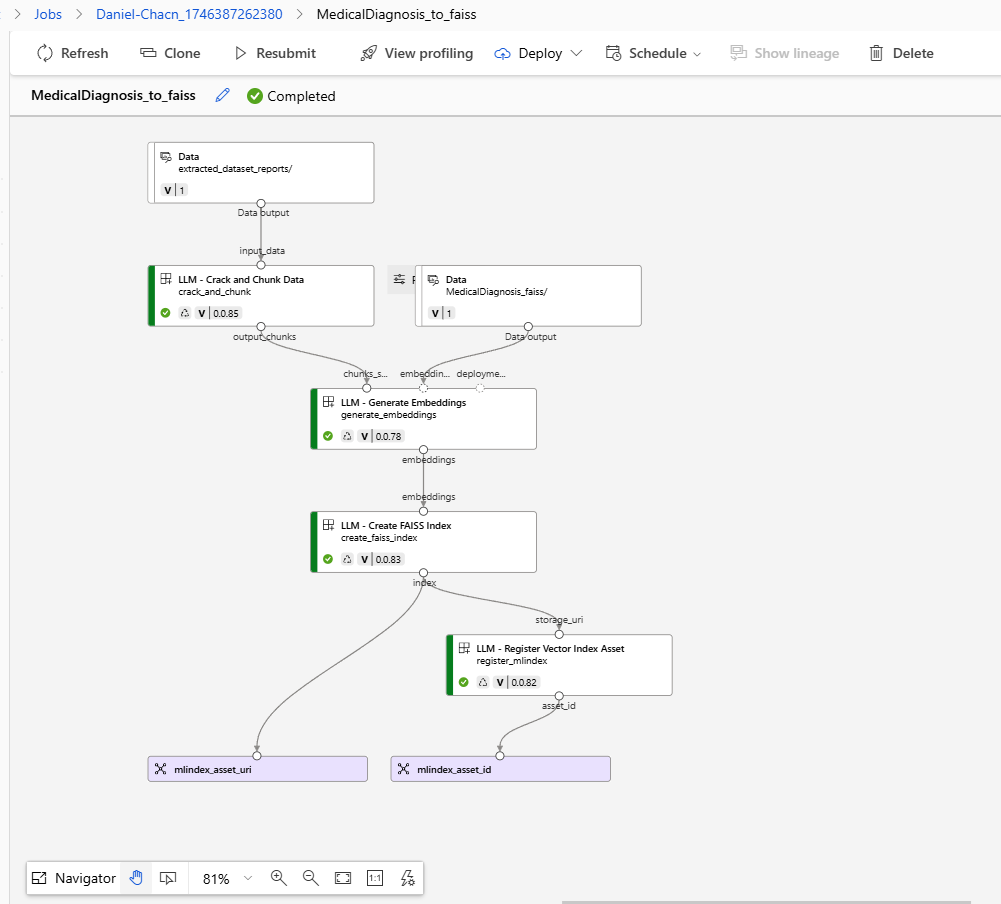

In [40]:
from IPython.display import Image, display
display(Image(filename="RagPipeline.png"))

**Actionable Insights and Recommendations**

**Recommendations**
- Maintain and expand the knowledge base:  Keep documents current and relevant to ensure the model always provides accurate, trustworthy answers.
- Leverage analytics for improvement: Monitor queries, feedback, and accuracy metrics to refine both the retrieval logic and the content.
- Plan for scalability: Ensure the infrastructure can support more users and larger datasets as adoption grows.

**Key Takeaways**
- The model successfully retrieves and synthesizes relevant information from the company’s knowledge base, reducing the time employees spend searching for answers.
- User interaction data provides valuable insights into what information is most sought after, enabling the business to identify gaps and opportunities.

#### Power Ahead!